In [1]:
# import modules 
import os
import datetime
import glob
import rasterio
from rasterio.merge import merge
from collections import Counter
import pandas as pd 

import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
start = datetime.datetime.now()


In [2]:
#define paths 
processing_path = "/media/knn/DATA/modis_hdf_data"
processing_path_modis = os.path.join(processing_path, "merged_daily")
processing_path_mars = os.path.join(processing_path, "mars_data")
snow_threshold = 50 


In [3]:
modis_set = list(set([file_.split("_")[1] for file_ in glob.glob1(processing_path_modis, "*.tif" )]))
mars_set = list(set([file_.split("_")[1] for file_ in glob.glob1(processing_path_mars, "*.tif" )]))
modis_set.sort()
mars_set.sort()
    
print(len(modis_set),  len(mars_set) )



212 202


In [ ]:
df = pd.DataFrame(columns= ["Date",
                            "SumA","SumB","SumC","SumD",
                            "POD","FAR","Accuracy", 
                            "Start", "Duration"],
                  index=modis_set)
df_data = pd.DataFrame(columns= ["Month",
                            "A", "B", "C", "D"],
                  index=[11,12,1,2,3,4,5])
start = datetime.datetime.now()
prev = 0 ; 
for en, date_ in  enumerate(modis_set):
    inner = datetime.datetime.now()
    in_date_format = datetime.datetime.strptime(date_, "%Y%m%d")
    month = in_date_format.month
    if prev != month or en == 0 :
        A,B,C,D =[np.zeros((8999, 35999)) for row in range(4)]
        df_data.loc[month] =[month, A, B ,C, D]
        
    
        
    print(date_, in_date_format )
    modis_data = rasterio.open(os.path.join(processing_path_modis, "MOD10A1_"+date_+"_europe_resampled.tif"))
    
    try: 
        mars_data = rasterio.open(os.path.join(processing_path_mars, "h35_"+date_+"_day_TSMS.tif"))
    except: 
        continue 
    mars_data = mars_data.read(1)
    modis_data = modis_data.read(1)
    
    data_inter = []
    data_inter = np.where(mars_data <=100, mars_data, 255)
    data_inter = np.where(data_inter <snow_threshold, 0, data_inter )
    data_inter_mars = np.where((data_inter >= snow_threshold ) & (data_inter<=100), 1, data_inter)
    
    data_inter = []
    data_inter = np.where(modis_data <=100, modis_data, 255)
    data_inter = np.where(data_inter < snow_threshold, 0, data_inter )
    data_inter_modis = np.where((data_inter >= snow_threshold) & (data_inter<=100), 1, data_inter)

    # Hits(A)
    A = np.where((data_inter_modis == 1) &  (data_inter_mars == 1),1, 0)
    # False Alarms (B)
    B = np.where((data_inter_modis == 0) &  (data_inter_mars == 1),1, 0)
    # Misses (C)
    C = np.where((data_inter_modis == 1) &  (data_inter_mars == 0),1, 0)
    # Correct Negatives (D)
    D = np.where((data_inter_modis ==0) &  (data_inter_mars ==0),1, 0) 
    
    a = np.sum(A)
    b = np.sum(B)
    c = np.sum(C)
    d = np.sum(D)

    pod = a / (a+c)
    far = b / (a+b)
    acc = (a+d) / (a+b+c+d)
    end = datetime.datetime.now()
    duration = end - inner 
    df.loc[date_] = [pd.Timestamp(date_),a,b,c,d,pod, far, acc, start, duration.total_seconds()]
    df_data.loc[month] = [month, 
                          df_data.loc[month]['A'] + A,
                          df_data.loc[month]['B'] + B,
                          df_data.loc[month]['C'] + C,
                          df_data.loc[month]['D'] + D]
    prev = month

20181101 2018-11-01 00:00:00
20181102 2018-11-02 00:00:00
20181103 2018-11-03 00:00:00
20181104 2018-11-04 00:00:00
20181105 2018-11-05 00:00:00
20181106 2018-11-06 00:00:00


In [5]:
np.max(df_data.loc[month]['A'])

4.0

In [11]:
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
df_data.loc[month] + A  

Month    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
A        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 11, dtype: object

In [19]:
df.to_excel(os.path.join(processing_path, "data_frame_last_part.xlsx"))  

In [3]:
# Read Data 

date_ = "20181101"
# date_flag = "MOD10A1_20190524_europe_resampled.tif"
mars_data = rasterio.open(os.path.join(processing_path_test, "MOD10A1_"+date_+"_europe_resampled.tif"))
modis_data = rasterio.open(os.path.join(processing_path_test, "modis_"+date_+".tif"))

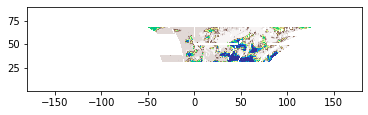

<AxesSubplot:>

In [22]:
# Display modis data 
show(modis_data, cmap='terrain')

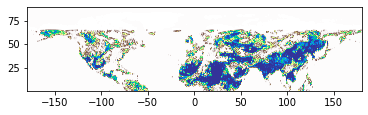

<AxesSubplot:>

In [20]:
# Display modis data 
show(mars_data, cmap='terrain')

In [4]:
# read data into memory 
mars_data = mars_data.read(1)
modis_data = modis_data.read(1)

In [5]:
#create intermediate data  for mars_data 
data_inter = np.where(mars_data <=100, mars_data, 255)
data_inter = np.where(data_inter <snow_threshold, 0, data_inter )
data_inter_mars = np.where((data_inter >= snow_threshold ) & (data_inter<=100), 1, data_inter)
print(np.unique(data_inter_mars))

# show(data_inter, cmap='terrain')
# 0:land 1:snow 255:other

[  0.   1. 255.]


In [10]:
#create intermediate data  for modis_data 
data_inter = np.where(modis_data <=100, modis_data, 255)
data_inter = np.where(data_inter < snow_threshold, 0, data_inter )
data_inter_modis = np.where((data_inter >= snow_threshold) & (data_inter<=100), 1, data_inter)
print(np.unique(data_inter_modis))

# show(data_inter, cmap='terrain')
# 0:land 1:snow 255:other


[  0   1 255]


In [33]:
t = np.where(data_inter_snow==0,1, 255)

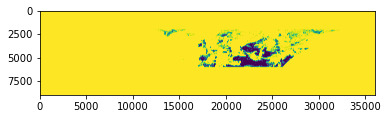

In [36]:
plt.imshow(t)

In [11]:
# Hits(A)
A = np.where((data_inter_modis == 1) &  (data_inter_mars == 1),1, 0)

# False Alarms (B)
B = np.where((data_inter_modis == 0) &  (data_inter_mars == 1),1, 0)

# Misses (C)
C = np.where((data_inter_modis == 1) &  (data_inter_mars == 0),1, 0)

# Correct Negatives (D)
D = np.where((data_inter_modis ==0) &  (data_inter_mars ==0),1, 0) 


In [14]:
np.unique(A, return_counts=True)

(array([0, 1]), array([323676607,    278394]))

In [26]:
a = np.sum(A)
b = np.sum(B)
c = np.sum(C)
d = np.sum(D)

pod = a / (a+c)
far = b/ (a+b)
acc = (a+d)/(a+b+c+d)

In [28]:
pod

0.7073144085387697

In [30]:
acc

0.9656260516585112

In [32]:
np.unique(mars_data)

array([  0.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 251., 252., 253.], dtype=float32)

In [31]:
end = datetime.datetime.now()
print(start, end-start)


2021-01-22 01:05:44.871526 0:34:53.512424
